# Imputing Missing data

## **Introduction**

Missing data refers to the absence of values for certain observations and is an unavoidable problem in most data sources. Scikit-learn does not support missing values as input, so we need to remove observations with missing data or transform them into permitted values. The act of replacing missing data with statistical estimates of missing values is called **imputation**. The goal of any imputation technique is to produce a complete dataset that can be used to train machine learning models. **There are multiple imputation techniques we can apply to our data**. **The choice of imputation technique** we use will depend on whether **the data is missing at random**, **the number of missing values**, and the **machine learning model we intend to use**. In this chapter, we will discuss several missing data imputation techniques.

In [1]:
import random
import pandas as pd
import numpy as np

data = pd.read_csv('../data/crx.data', header=None)

varnames = ['A'+str(s) for s in range(1, 17)]

data.columns = varnames

data = data.replace('?', np.nan)

data['A2'] = data['A2'].astype('float')
data['A14'] = data['A14'].astype('float')

data['A16'] = data['A16'].map({'+':1, '-':0})

random.seed(9001)
values = [random.randint(0, len(data)) for p in range(0, 100)]
for var in ['A3', 'A8', 'A9', 'A10']:
    data.loc[values, var] = np.nan

data.to_csv('../data/creditApprovalUCI.csv', index=False)

## **Removing observations with missing data**

**Complete Case Analysis(CCA)**, also called **list-wise deletion of cases**, consists of **discarding those observations where the values in any of the variables are missing**. CCA can be applied to categorical and numerical variables. CCA is quick and easy to implement and has the advantage that it preserves the distribution of the variables, provided the data is missing at random and only a small proportion of the data is missing. However, if data is missing across many variables, CCA may lead to the removal of a big portion of the dataset.

### **How to do it**

In [2]:
# 1 First, we'll import the libraries
import pandas as pd

# 2 Load the Credit Approval Dataset
data = pd.read_csv('../data/creditApprovalUCI.csv')
# 3 Calculate the percentage of missing values
data.isnull().mean().sort_values(ascending=True)

A11    0.000000
A12    0.000000
A13    0.000000
A15    0.000000
A16    0.000000
A4     0.008696
A5     0.008696
A6     0.013043
A7     0.013043
A1     0.017391
A2     0.017391
A14    0.018841
A3     0.133333
A8     0.133333
A9     0.133333
A10    0.133333
dtype: float64

In [3]:
# 4 Now, we'll remove the observations with missing data in any of the variables:
data_cca = data.dropna()

> To remove observations where data is missing in a subset of variables, we can execute `data.dropna(subset=['A3', 'A4'])`. To remove observations if data is missing in all the variables, we can execute `data.dropna(how='all')`.

In [4]:
# 5 Let's print and compare the size of the original and complete case datasets:
print('Number of total observations: {}'.format(len(data)))
print('Number of observations with complete cases: {}'.format(len(data_cca)))

Number of total observations: 690
Number of observations with complete cases: 564


## **Performing mean or median imputation**

**`Mean` or `median` imputation consists of replacing missing values with the variable mean or median** . This can **only be performed in numerical variables**. The **mean or the median is calculated using a train set**, and these values are used to **impute missing data in train and test sets**, as well as in future data we intend to score with the machine learning model. Therefore, we need to store these `mean` and `median` values. `Scikit-learn` and `Feature-engine` transformers learn the parameters from the train set and store these parameters for future use. So, in this recipe, we will learn how to perform mean or median imputation using the scikit-learn and Feature-engine libraries and pandas for comparison.

> <font color=cyan>Use mean imputation if variables are normally distributed and median imputation otherwise</font>. **Mean and median imputation may distort the distribution of the original variables if there is a high percentage of missing data**.

### **How to do it**

In [23]:
# 1 Import the libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from feature_engine.imputation import MeanMedianImputer
# 2 Let's load the dataset
data = pd.read_csv('../data/creditApprovalUCI.csv')
# 3 In mean and median imputation, the mean or median values should be
# calculated using the variables in the train set, therefore let's separate
# the data into and sets and their respective targets
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=.3, random_state=0)

> ou can check the size of the returned datasets using pandas' shape: `X_train.shape`, `X_test.shape`.

In [25]:
# 4 Let's check the percentage of missing values in the train set
X_train.isnull().mean()

A1     0.008282
A2     0.022774
A3     0.140787
A4     0.008282
A5     0.008282
A6     0.008282
A7     0.008282
A8     0.140787
A9     0.140787
A10    0.140787
A11    0.000000
A12    0.000000
A13    0.000000
A14    0.014493
A15    0.000000
dtype: float64

In [7]:
# 5 Let's replace the missing values with the median in five numerical variables using pandas:
for var in ['A2', 'A3', 'A8', 'A11', 'A15']:
    value = X_train[var].median()
    X_train[var] = X_train[var].fillna(value)
    X_test[var] = X_test[var].fillna(value)

Note **how we calculate the median using the train set and then use this value to replace the missing data in the train and test sets**.

> To impute missing data with the mean, we use pandas' mean():`value = X_train[var].mean()`.

In [8]:
X_train.isnull().median()

A1     0.0
A2     0.0
A3     0.0
A4     0.0
A5     0.0
A6     0.0
A7     0.0
A8     0.0
A9     0.0
A10    0.0
A11    0.0
A12    0.0
A13    0.0
A14    0.0
A15    0.0
dtype: float64

> The pandas' `fillna()` returns a new dataset with imputed values by default. We can set the inplace argument to `True` to replace missing data in the original dataframe: `X_train[var].fillna(inplace=True)`.

Now, let's impute missing values by the median using scikit-learn so that we can store learned parameters.

In [9]:
# 6 To do this, let's separate the original dataset into train and test sets, keeping only the numerical variables:
X_train, X_test, y_train, y_test = train_test_split(
    data[['A2', 'A3', 'A8', 'A11', 'A15']], data['A16'], 
    test_size=0.3, random_state=0)

> `SimpleImputer()` from scikit-learn **will impute all variables in the dataset**. Therefore, **if we use mean or median imputation and the dataset contains categorical variables, we will get an error**. 

In [10]:
# 7 Let's create a median imputation transformer using SimpleImputer() from scikit-learn:
imputer = SimpleImputer(strategy='median')

> To perform mean imputation, we should set the strategy to mean: `imputer = SimpleImputer(strategy = 'mean')`.

In [11]:
# 8 Let's fit the SimpleImputer() to the train set so that it learns the median values of the variables:
imputer.fit(X_train)
# 9 Let's inspect the learned median values:
imputer.statistics_

array([28.835,  2.75 ,  1.   ,  0.   ,  6.   ])

In [12]:
# 10 Let's replace missing values with medians:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [26]:
type(X_train)

pandas.core.frame.DataFrame

> `SimpleImputer()` returns NumPy arrays. We can transform the array into a dataframe using `pd.DataFrame(X_train, columns = ['A2', 'A3', 'A8', 'A11', 'A15'])`. Be mindful of the order of the variables.

Finally, let's perform median imputation using `MeanMedianImputer()` from `Feature-engine`. First, we need to load and divide the dataset, just like we did in step 2 and step 3. Next, we need to create an imputation transformer.

In [19]:
# 11 Let's set up a median imputation transformer using MeanMedianImputer() from Feature-engine specifying the variables to impute:
median_imputer = MeanMedianImputer(imputation_method='median', variables=['A2', 'A3', 'A8', 'A11', 'A15'])

> To perform mean imputation, change the imputation method, as follows: `MeanMedianImputer(imputation_method='mean')`.

In [29]:
# 12 Let's fit the median imputer so that it learns the median values for each of the specified variables:
median_imputer.fit(X_train)
# 13 Let's inspect the learned medians:
median_imputer.imputer_dict_

{'A2': 28.835, 'A3': 2.75, 'A8': 1.0, 'A11': 0.0, 'A15': 6.0}

In [30]:
# 14 Finally, let's replace the missing values with the median:
X_train = median_imputer.transform(X_train)
X_test = median_imputer.transform(X_test)

In [33]:
X_train[['A2','A3', 'A8', 'A11', 'A15']].isnull().mean()

A2     0.0
A3     0.0
A8     0.0
A11    0.0
A15    0.0
dtype: float64

### **There's more**

Scikit-learn's `SimpleImputer()` **imputes all the variables in the dataset** but, with scikit-learn's `ColumnTransformer()`, we can `select specific variables we want to impute`. For details on how to use `ColumnTransformer()` with `SimpleImputer()`, see ***the Assembling an imputation pipeline with scikit-learn*** recipe.

## **Implementing mode or frequent category imputation**

Mode imputation consists of replacing missing values with the mode. We normally use this procedure in categorical variables, hen the **frequent category imputation** name. Frequent categories are estimated using the train set and then used to impute values in train, test and future datasets. Thus, we need to learn and store these parameters, which we can do using `scikit-learn` and `Feature-engine`'s `transformers`

> <font color=cyan>If the percentage of missing values is high, frequent category imputation may distort the original distribution of categories.</font>

### **How to do it**

In [54]:
# 1 Let's do the importations
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from feature_engine.imputation import CategoricalImputer

# 2 Let's load the dataset
data = pd.read_csv('../data/creditApprovalUCI.csv')

# 3 Frequent categories should be calculated using the train set variables, so let's separate the data
# into train and test sets and their respective targets
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=.3, random_state=0)

# 4 Let's replace missing values with the frequent category category, taht is, the mode,
# in four categorical variables
for var in ['A4', 'A5', 'A6', 'A7']:
    value = X_train[var].mode()[0]
    X_train[var] = X_train[var].fillna(value)
    X_test[var] = X_test[var].fillna(value)

> The pandas' `fillna()` returns a new dataset with imputed values by default. Instead of doing this, we can replace missing data in the original dataframe by executing `X_train[var].fillna(inplace=True)`.

In [56]:
# 5 First, let's separate the original dataset into train and test sets and only retain the categorical variables:
X_train, X_test, y_train, y_test = train_test_split(data[['A4', 'A5', 'A6', 'A7']], data['A16'], test_size=.3, random_state=0)
# 6 Let's create a frequent category imputer with SimpleImputer() from scikit-learn
imputer = SimpleImputer(strategy='most_frequent')

`SimpleImputer()` from scikit-learn **will learn the mode for numerical and categorical variables alike**. But **in practice, mode imputation is done for categorical variables only**.

In [57]:
# 7 Let's fit the imputer to the train set so that it learns the most frequent values
imputer.fit(X_train)
# 8 Let's inspect the most frequent values learned by the imputer
imputer.statistics_

array(['u', 'g', 'c', 'v'], dtype=object)

In [58]:
# 9 Let's replace missing values with frequent categories
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

Note that `SimpleImputer()` will return a NumPy array and not a pandas dataframe.
Finally, let's impute missing values using Feature-engine. First, we need to load and separate the data into train and test sets, just like we did in step 2 and step 3 in this recipe.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(data[['A4', 'A5', 'A6', 'A7']], data['A16'], test_size=.3, random_state=0)

In [73]:
# 10 Next, let's create a frequent category imputer with CategoricalImputer
mode_imputer = CategoricalImputer(variables=['A4', 'A5', 'A6', 'A7'])

`CategorcalImputer()` will select all categorical variables in the train set by default; that is, unless we pass a list of variables to impute.

In [75]:
# 11 Let's fit the imputation transformer to the train set so that it learns the most
# frequent categories
mode_imputer.fit(X_train)
# 12 Let's inspect the learned frequent categories
mode_imputer.imputer_dict_

{'A4': 'Missing', 'A5': 'Missing', 'A6': 'Missing', 'A7': 'Missing'}

In [76]:
# 13 Finally, let's replace the missing values with frequent categories:
X_train = mode_imputer.transform(X_train)
X_test = mode_imputer.transform(X_test)

`CategoricalImputer()` returns a pandas dataframe with the imputed values.

Remember that you can check that the categorical variables do not contain missing values by using `X_train[['A4', 'A5', 'A6', 'A7']].isnull().mean()`.

## **Replacing missing values with an arbitrary number**

Arbitrary number imputation consists of replacing missing values with an arbitrary value. Some commonly used values include $999$, $9999$, or $-1$ for positive distributions. This method is suitable for numerical variables. A similar method for categorical variables will be discussed in the *Capturing missing values in a bespoke category* recipe.

When replacing missing values with an arbitrary number, **we need to be careful not to select a value close to the mean or the median, or any other common value of the distribution**.

> Arbitrary number imputation can be used when data is not missing at random, when we are building non-linear models, and when the percentage of missing data is high. This imputation technique distorts the original variable distribution.

### **How to do it**

In [1]:
# 1 Import pandas and the required functions and classes from scikit-learn and Feature-engine:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from feature_engine.imputation import ArbitraryNumberImputer
# 2 Let's load the dataset:
data = pd.read_csv('../data/creditApprovalUCI.csv')
# 3 Let's separate the data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)
# Normally, we select arbitrary values that are bigger than the maximum value of the distribution.
# Let's find the maximum value of four numerical variables:
X_train[['A2','A3', 'A8', 'A11']].max()

A2     76.750
A3     26.335
A8     20.000
A11    67.000
dtype: float64

In [2]:
# 5 Let's replace the missing values with 99 in the numerical variables that we specified in step 4:
for var in ['A2','A3', 'A8', 'A11']:
    X_train[var].fillna(99, inplace=True)
    X_test[var].fillna(99, inplace=True)

Now, we'll impute missing values with an arbitrary number using scikit-learn instead.

In [3]:
# 6 First, let's separate the data into train and test sets while keeping only the numerical variables:
X_train, X_test, y_train, y_test = train_test_split(data[['A2', 'A3', 'A8', 'A11']], data['A16'], test_size=0.3, random_state=0)
# 7 Let's set up SimpleImputer() so that it replaces any missing values with 99:
imputer = SimpleImputer(strategy='constant', fill_value=99)
# 8 Let's fit the imputer to the train set:
imputer.fit(X_train)
# 9 Let's replace the missing values with 99:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

o finish, let's impute missing values using Feature-engine. First, we need to load the data and separate it into train and test sets, just like we did in step 2 and step 3.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data[['A2', 'A3', 'A8', 'A11']], data['A16'], test_size=0.3, random_state=0)

# 10 Next, let's create an imputation transformer with Feature-engine's ArbitraryNumberImputer() in order to replace any missing values with 99 and specify the variables from which missing data should be imputed:
imputer = ArbitraryNumberImputer(arbitrary_number=99, variables=['A2','A3', 'A8', 'A11']) 
# ArbitraryNumberImputer() will automatically select all numerical variables in the train set; that is, unless we specify which variables to impute in a list.
# 11 Let's fit the arbitrary number imputer to the train set:
imputer.fit(X_train)
# 12 Finally, let's replace the missing values with 99:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

## **Capturing missing values in a bespoke category**

Missing data in categorical variables can be treated as a different category, so it is common to replace missing values with the Missing string. In this recipe, we will learn how to do so using pandas, scikit-learn, and Feature-engine.

### **How to do it**

In [6]:
# 1 Import pandas and the required functions and classes from scikit-learn and Feature-engine:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from feature_engine.imputation import CategoricalImputer
# 2 Let's load the dataset:
data = pd.read_csv('../data/creditApprovalUCI.csv')
# 3 Let's separate the data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)
# 4 Let's replace missing values in four categorical variables by using the Missing string:
for var in ['A4', 'A5', 'A6', 'A7']:
    X_train[var].fillna('Missing', inplace=True)
    X_test[var].fillna('Missing', inplace=True)
# Alternatively, we can replace missing values with the Missing string using scikit-learn as follows.

# 5 First, let's separate the data into train and test sets while keeping only categorical variables:
X_train, X_test, y_train, y_test = train_test_split(data[['A4', 'A5', 'A6', 'A7']], data['A16'], test_size=0.3, random_state=0)
# 6 Let's set up SimpleImputer() so that it replaces missing data with the Missing string and fit it to the train set:
imputer = SimpleImputer(strategy='constant', fill_value='Missing')
imputer.fit(X_train)

SimpleImputer(fill_value='Missing', strategy='constant')

> `impleImputer()` from scikit-learn **will replace missing values with Missing in both numerical and categorical variables**. Be careful of this behavior or you will end up accidentally casting your numerical variables as objects.

In [7]:
# 7 Let's replace the missing values:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

> Remember that SimpleImputer() returns a NumPy array, which you can transform into a dataframe using `pd.DataFrame(X_train, columns = ['A4', 'A5', 'A6', 'A7'])`.

To finish, let's impute missing values using Feature-engine. First, we need to separate the dataset, just like we did in step 3 of this recipe. 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)
# 8 Next, let's set up the CategoricalVariableImputer() from Feature-engine, which replaces missing values with the Missing string, specifying the categorical variables to impute, and then fit the transformer to the train set:
imputer = CategoricalImputer(variables=['A4', 'A5', 'A6', 'A7'])
imputer.fit(X_train)
# If we don't pass a list with categorical variables, FrequentCategoryImputer() will select all categorical variables in the train set.
# 9 Finally, let's replace the missing values:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

## **Replacing missing values with a value at the end of the distribution**

Replacing missing values with a value at the end of the variable distribution is equivalent to replacing them with an arbitrary value, but instead of identifying the arbitrary values manually, these values are automatically selected as those at the very end of the variable distribution. The values that are used to replace missing information are estimated using the mean plus or minus three times the standard deviation if the variable is normally distributed, or the inter-quartile range $(IQR)$ proximity rule otherwise. According to the IQR proximity rule, missing values will be replaced with the $\text{ 75th quantile} + (IQR \times 1.5)$ at the right tail or by the $\text{25th quantile} - (IQR \times 1.5)$ at the left tail. The IQR is given by the $\text{75th quantile} - \text{the 25th quantile}$.

> Some users will also identify the minimum or maximum values of the variable and replace missing data as a factor of these values, for example, three times the maximum value.

The value that's used to replace missing information should be learned from the train set and stored to impute train, test, and future data. Feature-engine offers this functionality. In this recipe, we will implement end-of-tail imputation using pandas and Feature-engine.

> End-of-tail imputation may distort the distribution of the original variables, so it may not be suitable for linear models.

### **How to do it**

In [16]:
# 1 Let's import the libs
import pandas as pd
from sklearn.model_selection import train_test_split
from feature_engine.imputation import EndTailImputer
# 2 Let's load the dataset
data = pd.read_csv('../data/creditApprovalUCI.csv')
# 3 Let's separate the data intro train and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=.3, random_state=0)
# 4 Let's loop over 5 numerical variables, calculate IQR, determine the value of the 75th quantile
# plus 1.5 times the IQR, and replace the missing observations in the train and test sets with that
# value
for var in ['A2', 'A3', 'A8', 'A11', 'A15']:
    IQR = X_train[var].quantile(0.75) - X_train[var].quantile(0.25)
    value = X_train[var].quantile(0.75) + 1.5 * IQR

    X_train[var] = X_train[var].fillna(value)
    X_test[var] = X_test[var].fillna(value)

In [17]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


> If we want to use the Gaussian approximation instead of the IQR proximity rule, we can calculate the value to replace missing data using `value = X_train[var].mean() + 3*X_train[var].std()`. Some users also calculate the value as `X_train[var].max()*3`.

Note how we calculated the value to impute the missing data using the variables in the train set and then used this to impute train and test sets.

We can also place replace missing data with values at the left tail of the distribution using `value = X_train[var].quantile(0.25) - 1.5 * IQR` or `value = X_train[var].mean() - 3*X_train[var].std()`.

To finish, let's impute missing values using Feature-engine. First, we need to load and separate the data into train and test sets, just like in step 2 and step 3 of this recipe.

In [24]:
# 5 Next, let's set up EndTailImputer() so that we can estimate a value at the right tail using the IQR proximity rule and specify the variables we wish to impute:
imputer = EndTailImputer(imputation_method='gaussian', tail='right', variables=['A2', 'A3', 'A8', 'A11', 'A15'])

To use mean and standard deviation to calculate the replacement values, we need to set `imputation_method='iqr'`. We can use `'left'` or `'right'` in the `tail` argument to specify the side of the distribution where we'll place the missing values.

In [25]:
# 6 Let's fit the EndTailImputer() to the train set so that it learns the parameters:
imputer.fit(X_train)
# 7 Let's inspect the learned values:
imputer.imputer_dict_

{'A2': 71.35031102042569,
 'A3': 25.854124379795604,
 'A8': 13.675535600625327,
 'A11': 18.320547522636208,
 'A15': 12740.850618383236}

In [26]:
# 8 Finally let's replace the missing values
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [27]:

X_train[['A2', 'A3', 'A8', 'A11', 'A15']].isnull().sum()

A2     0
A3     0
A8     0
A11    0
A15    0
dtype: int64

### **How it works**

In this recipe, **we replaced the missing values in numerical variables with a value at the end of the distribution using pandas and Feature-engine**. These values were **calculated using the IQR proximity rule or the mean and standard deviation**. First, we loaded the data and divided it into train and test sets using `train_test_split()`, as described in the Performing mean or median imputation recipe.

## **Implementation random sample imputation**

**Random sampling imputation consists of extracting random observations from the pool of available values in the variable**. Random sampling imputation preserves the original distribution, which differs from the other imputation techniques we've discussed in this chapter and is suitable for numerical and categorical variables alike.

### **How to do it**

In [29]:
# 1 Let's imoport the libs
import pandas as pd
from sklearn.model_selection import train_test_split
from feature_engine.imputation import RandomSampleImputer
# 2 Let's load the dataset
data = pd.read_csv('../data/creditApprovalUCI.csv')
# 3 The random values that will be used to replace missing data
# should be extracted from the train set, so let's separate the
# data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=.3, random_state=0)
# 4 Let's calculate the number of missing values in the A2 variable
number_na = X_train['A2'].isnull().sum()
number_na

11

In [30]:
# 5 Let's extract 11 values at random from A2 for the imputation
random_sample_train = X_train['A2'].dropna().sample(number_na, random_state=0)
# 6 We can only use one pandas Series to replace values in another pandas
# Series if their indexes are identical, so let's re-index the extracted
# random values so that they match the index of the missing values in the
# original dataframe:
random_sample_train.index = X_train[X_train['A2'].isnull()].index
# 7 Now let's replace the missing values in the original dataset with randomly
# extracted values
X_train.loc[X_train['A2'].isnull(), 'A2'] = random_sample_train
# 8 Now, let's combine step 4 to step 7 in a loop to replace the missing data
# in the variables in various train and test sets:
for var in ['A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']:
    # extract a random sample
    random_sample_train = X_train[var].dropna().sample(X_train[var].isnull().sum(), random_state=0)
    random_sample_test = X_train[var].dropna().sample(X_test[var].isnull().sum(), random_state=0)
    # re-index the randomly extracted sample
    random_sample_train.index = X_train[X_train[var].isnull()].index
    random_sample_test.index = X_test[X_test[var].isnull()].index
    # replace the NA
    X_train.loc[X_train[var].isnull(), var] = random_sample_train
    X_test.loc[X_test[var].isnull(), var] = random_sample_test

> Note how we always extract values from the train set, but we calculate the number of missing values and the index using the train or test sets, respectively.

To finish, let's impute missing values using Feature-engine. First, we need to separate the data into train and test, just like we did in step 3 of this recipe.

In [31]:
# 9 Next, let's set up RandomSamplemputer() and fit it to the train set:
imputer = RandomSampleImputer()
imputer.fit(X_train)

RandomSampleImputer()

> `RandomSampleImputer()` will replace the values in all variables in the dataset by default.

We can specify the variables to impute by passing variable names in a list to the imputer using `imputer = RandomSampleImputer(variables = ['A2', 'A3'])`.

In [32]:
# 10 Finally, let's replace the missing values:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

## **Adding a missing value indicator variable**

**A missing indicator is a binary variable that specifies whether a value was missing for an observation ($1$) or not ($0$)**. **It is common practice to replace missing observations by the mean, median, or mode while flagging those missing observations with a missing indicator, thus covering two angles: if the data was missing at random, this would be contemplated by the mean, median, or mode imputation, and if it wasn't, this would be captured by the missing indicator**. In this recipe, we will learn how to add missing indicators using NumPy, scikit-learn, and Feature-engine

### **Getting ready**

For an example of the implementation of missing indicators, along with mean imputation, check out the Winning the *KDD Cup Orange Challenge with Ensemble Selection* article, which was the winning solution in the KDD 2009 cup: http://www.mtome.com/Publications/CiML/CiML-v3-book.pdf.

### **How to do it**

In [14]:
# 1 Let's import the required libs
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import MissingIndicator
from feature_engine.imputation import AddMissingIndicator
# 2 Let's separate the data into and tes sets
data = pd.read_csv('../data/creditApprovalUCI.csv')
# 3 Let's separate the data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)
# 4 Using NumPy, we'll add a missing indicator to the numerical and categorical variables in a loop:
for var in ['A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']:
    X_train[var + '_NA'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_NA'] = np.where(X_test[var].isnull(), 1, 0)
# 5 Let's inspect the result of the preceding code block:
X_train.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A13,A14,A15,A1_NA,A3_NA,A4_NA,A5_NA,A6_NA,A7_NA,A8_NA
596,a,46.08,3.000,u,g,c,v,2.375,t,t,...,g,396.0,4159,0,0,0,0,0,0,0
303,a,15.92,2.875,u,g,q,v,0.085,f,f,...,g,120.0,0,0,0,0,0,0,0,0
204,b,36.33,2.125,y,p,w,v,0.085,t,t,...,g,50.0,1187,0,0,0,0,0,0,0
351,b,22.17,0.585,y,p,ff,ff,0.000,f,f,...,g,100.0,0,0,0,0,0,0,0,0
118,b,57.83,7.040,u,g,m,v,14.000,t,t,...,g,360.0,1332,0,0,0,0,0,0,0


Now, let's add missing indicators using Feature-engine instead. First, we need to load and divide the data, just like we did in step 2 and step 3 of this recipe.

In [15]:
# 6 Next, let's set up a transformer that will add binary indicators to all the variables in the dataset using AddNaNBinaryImputer() from Feature-engine:
imputer = AddMissingIndicator()

> We can specify the variables which should have missing indicators by passing the variable names in a list: `imputer = AddMissingIndicator(variables = ['A2', 'A3'])`. Alternatively, the imputer will add indicators to all the variables.

In [16]:
# 7 Let's fit AddNaNBinaryImputer() to the train set:
imputer.fit(X_train)
# 8 Finally, let's add the missing indicators:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

> We can inspect the result using `X_train.head()`; it should be similar to the output of step 5 in this recipe.

In [17]:
# 9 Next, we'll set up a MissingIndicator(). Here, we will add indicators only to variables with missing data:
indicator = MissingIndicator(features='missing-only')
# 10 Let's fit the transformer so that it finds the variables with missing data in the train set:
indicator.fit(X_train) 

MissingIndicator()

Now, we can concatenate the missing indicators that were created by `MissingIndicator()` to the train set.

In [18]:
# 11 First, let's create a column name for each of the new missing indicators with a list comprehension:
indicator_cols = [c + '_NA' for c in X_train.columns[indicator.features_]]

The `features_` attribute contains the indices of the features for which missing indicators will be added. If we pass these indices to the train set column array, we can get the variable names.

In [19]:
# 12 Next, let's concatenate the original train set with the missing indicators, which we obtain using the transform method:
X_train = pd.concat([
    X_train.reset_index(),
    pd.DataFrame(indicator.transform(X_train), columns=indicator_cols)],
    axis=1)

> Scikit-learn transformers return NumPy arrays, so to concatenate them into a dataframe, we must cast it as a dataframe using pandas `DataFrame()`.

The result of the preceding code block should contain the original variables, plus the indicators.

## **Performing multivariate imputation by chained equations**

Multivariate imputation methods, as opposed to univariate imputation, use the entire set of variables to estimate the missing values. In other words, **the missing values of a variable are modeled based on the other variables in the dataset**. **Multivariate imputation by chained equations (MICE)** is a multiple imputation technique that models each variable with missing values as a function of the remaining variables and uses that estimate for imputation. MICE has the following basic steps:

1. A simple univariate imputation is performed for every variable with missing data, for example, **median imputation**.
2. One specific variable is selected, say,` var_1`, and the missing values are set back to missing.
3. **A model that's used to predict** `var_1` **is built based on the remaining variables** in the dataset.
4. The **missing values** of `var_1` are **replaced with the new estimates**.
5. Repeat step 2 to step 4 for each of the remaining variables.

Once all the variables have been modeled based on the rest, a cycle of imputation is concluded. Step 2 to step 4 are performed multiple times, typically 10 times, and the imputation values after each round are retained. The idea is that, by the end of the cycles, the distribution of the imputation parameters should have converged.

> Each variable with missing data can be modeled based on the remaining variable by using multiple approaches, for example, linear regression, Bayes, decision trees, k-nearest neighbors, and random forests.

### **Getting ready**

To learn more about MICE, take a look at the following links:

* *A multivariate technique for multiplying imputing missing values using a sequence of regression models*: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.405.4540&rep=rep1&type=pdf

* *Multiple Imputation by Chained Equations: What is it and how does it work?*: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/

We will perform MICE imputation using `IterativeImputer()` from scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer.

### **How to do it**

In [21]:
# 1 Let's import the required python libs
import pandas as pd
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 2 Load the dataset with some numerical variables
variables = ['A2', 'A3', 'A8', 'A11', 'A14', 'A16']
data = pd.read_csv('../data/creditApprovalUCI.csv', usecols=variables)

"""
The models that will be used to estimate missing values should be built
on the train data and used to impute values in the train, test, and
future data:
"""
# 3 Let's divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=.3, random_state=0)
# 4 let's create a MICE imputer using Bayes regression as an estimator, specifying
# the number of iteration cycles and setting random_state for reproductibility
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)

> `IterativeImputer()` contains other useful arguments. For example, we can specify **the first imputation strategy using the initial_strategy parameter** and **specify how we want to cycle over the variables either randomly**, or **from the one with the fewest missing values to the one with the most**.

In [22]:
# 5 Let's fit IterativeImputer to the train set so that it trains the estimators
# to predict the missing values in each variable
imputer.fit(X_train)

# 6 Finally, let's fill in missing values in both train and test set
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)
# Remember that scikit-learn returns NumPy arrays and not dataframes.

### **How it works**

In this recipe, we performed MICE using `IterativeImputer()` from scikit-learn. First, we loaded data using pandas `read_csv()` and separated it into train and test sets using scikit-learn's `train_test_split()`. Next, we created a multivariate imputation object using the `IterativeImputer()` from scikit-learn. We specified that we wanted to estimate missing values using Bayes regression and that we wanted to carry out 10 rounds of imputation over the entire dataset. We fitted `IterativeImputer()` to the train set so that each variable was modeled based on the remaining variables in the dataset. Next, we transformed the train and test sets with the `transform()` method in order to replace missing data with their estimates.

### **There's more**

Using `IterativeImputer()` from scikit-learn, we can model variables using multiple algorithms, such as Bayes, knn, decision trees and random forests.

c:\Users\HP\miniconda3\envs\sklearn\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\HP\miniconda3\envs\sklearn\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


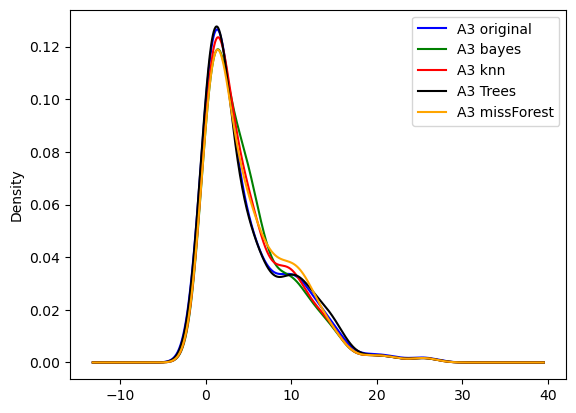

In [23]:
# 1 Import the libs
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

# 2 Load the data and separate the train and test sets
variables = ['A2','A3','A8', 'A11', 'A14', 'A15', 'A16']
data = pd.read_csv('../data/creditApprovalUCI.csv', usecols=variables)
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

# 3 Buid MICE using different modeling strategies
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=0)

imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=5),
    max_iter=10,
    random_state=0)

imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(
        max_features='sqrt', random_state=0),
    max_iter=10,
    random_state=0)

imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(
        n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0)

"""
Note how, in the preceding code block,
we create four different MICE imputers,
each with a different machine learning
algorithm which will be used to model every
variable based on the remaining variables
in the dataset.
"""

# 4 Fit the MICE imputers to the train set:
imputer_bayes.fit(X_train)
imputer_knn.fit(X_train)
imputer_nonLin.fit(X_train)
imputer_missForest.fit(X_train)
# 5 Impute missing values in the train set:
X_train_bayes = imputer_bayes.transform(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_train_nonLin = imputer_nonLin.transform(X_train)
X_train_missForest = imputer_missForest.transform(X_train)
# 6 Convert the NumPy arrays into dataframes:
predictors = [var for var in variables if var !='A16']
X_train_bayes = pd.DataFrame(X_train_bayes, columns = predictors)
X_train_knn = pd.DataFrame(X_train_knn, columns = predictors)
X_train_nonLin = pd.DataFrame(X_train_nonLin, columns = predictors)
X_train_missForest = pd.DataFrame(X_train_missForest, columns = predictors)
# 7 Plot and compare the results:
fig = plt.figure()
ax = fig.add_subplot(111)

X_train['A3'].plot(kind='kde', ax=ax, color='blue')
X_train_bayes['A3'].plot(kind='kde', ax=ax, color='green')
X_train_knn['A3'].plot(kind='kde', ax=ax, color='red')
X_train_nonLin['A3'].plot(kind='kde', ax=ax, color='black')
X_train_missForest['A3'].plot(kind='kde', ax=ax, color='orange')

# add legends
lines, labels = ax.get_legend_handles_labels()
labels = ['A3 original', 'A3 bayes', 'A3 knn', 'A3 Trees', 'A3 missForest']
ax.legend(lines, labels, loc='best')
plt.show()

In the preceding plot, we can see that the different algorithms return slightly different distributions of the original variable.

## **Assembling an imputation pipeline with scikit-lean**

Datasets often **contain a mix of numerical and categorical variables**. In addition, **some variables may contain a few missing data points**, while **others will contain quite a big proportion**. The **mechanisms by which data is missing may also vary among variables**. Thus, **we may wish to perform different imputation procedures for different variables**. In this recipe, we will learn **how to perform different imputation procedures for different feature subsets using scikit-learn**.

### **How to do it**

In [30]:
# 1 Let's import the libs
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# 2 Load the dataset
data = pd.read_csv('../data/creditApprovalUCI.csv')

# 3 Let's divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=.3, random_state=0)
# 4 Let's group a subset of columns to which we want to apply different imputation
# techniques in lits
features_num_arbitrary = ['A3', 'A8']
features_num_median = ['A2', 'A14']
features_cat_frequent = ['A4', 'A5', 'A6', 'A7']
features_cat_missing = ['A1', 'A9', 'A10']
# 5 Let's create different imputation transformers using SimpleImputer()
# within the scikit-learn pipeline
imputer_num_arbitrary = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=99)),
])
imputer_num_median = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])
imputer_cat_frequent = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])
imputer_cat_missing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
])

# 6 Now, let's assemble the pipelines with the imputers within 
# ColumnTransformer() and assign them to the different feature subsets we created in step 4:
preprocessor = ColumnTransformer(transformers=[
    ('imp_num_arbitrary', imputer_num_arbitrary, features_num_arbitrary),
    ('imp_num_median', imputer_num_median, features_num_median),
    ('imp_cat_frequent', imputer_cat_frequent, features_cat_frequent),
    ('imp_cat_missing', imputer_cat_missing, features_cat_missing),
], remainder='passthrough')

# 7 Next, we need to fit the preprocessor to the train set so that the imputation parameters are learned:
preprocessor.fit(X_train)

# 8 Finally let's replace the missing values in the train and test sets:
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

"""
Remember that scikit-learn transformers return NumPy arrays. The beauty of this procedure
is that we can save the preprocessor in one object to perpetuate all the parameters
that are learned by the different transformers
"""

'\nRemember that scikit-learn transformers return NumPy arrays. The beauty of this procedure\nis that we can save the preprocessor in one object to perpetuate all the parameters\nthat are learned by the different transformers\n'

In [31]:
X_train

array([[3.0, 2.375, 46.08, ..., 't', 'g', 4159],
       [2.875, 0.085, 15.92, ..., 'f', 'g', 0],
       [2.125, 0.085, 36.33, ..., 'f', 'g', 1187],
       ...,
       [0.665, 1.665, 19.58, ..., 'f', 'g', 5],
       [2.29, 2.29, 22.83, ..., 't', 'g', 2384],
       [3.29, 3.5, 40.58, ..., 't', 's', 0]], dtype=object)

## **Assembling an imputation pipeline with Feature-engine**

### **How to do it**

In [27]:
# 1 Let's import the libs
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer, ArbitraryNumberImputer, MeanMedianImputer
# 2 Let's load the dataset
data = pd.read_csv('../data/creditApprovalUCI.csv')
# 3 Let's divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=.3, random_state=0)
# 4 Let's create lists with the names of the variables that we want to apply specific
# imputation techniques to
features_num_arbitrary = ['A3', 'A8']
features_num_median = ['A2', 'A14']
features_cat_frequent = ['A4', 'A5', 'A6', 'A7']
features_cat_missing = ['A1', 'A9', 'A10']
# 5 Let's assemble an arbitrary value imputer, a median imputer, a frequent category imputer, and an imputer
# to replace any missing values with the Missing string within a scikit-learn pipeline:
pipe = Pipeline(steps=[
    ('imp_num_arbitrary', ArbitraryNumberImputer(
        variables = features_num_arbitrary)),
    ('imp_num_median', MeanMedianImputer(
        imputation_method = 'median', variables=features_num_median)),
    ('imp_cat_frequent', CategoricalImputer(
        variables = features_cat_frequent)),
    ('imp_cat_missing', CategoricalImputer(
        variables=features_cat_missing))
])
# 6 Let's fit the pipeline to the train set so that each imputer learns and stores the imputation parameters:
pipe.fit(X_train)
# 7 Finally, let's replace missing values in the train and test sets:
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [28]:
X_train.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
596,a,46.08,3.000,u,g,c,v,2.375,t,t,8,t,g,396.0,4159
303,a,15.92,2.875,u,g,q,v,0.085,f,f,0,f,g,120.0,0
204,b,36.33,2.125,y,p,w,v,0.085,t,t,1,f,g,50.0,1187
351,b,22.17,0.585,y,p,ff,ff,0.000,f,f,0,f,g,100.0,0
118,b,57.83,7.040,u,g,m,v,14.000,t,t,6,t,g,360.0,1332
